In [1]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = "dataset"
LABEL_PATH   = "labels"

IMG_WIDTH  = 256
IMG_HEIGHT = 256

CLASS_NAMES = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

print("Classes:", CLASS_NAMES)

Classes: ['cocci', 'healthy', 'salmo']


In [4]:
image_paths = []
label_paths = []
labels = []

for idx, cls in enumerate(CLASS_NAMES):
    img_dir = os.path.join(DATASET_PATH, cls)
    lbl_dir = os.path.join(LABEL_PATH, cls)

    for file in os.listdir(img_dir):
        if file.endswith(".jpg"):
            img_path = os.path.join(img_dir, file)
            lbl_path = os.path.join(lbl_dir, file.replace(".jpg", ".txt"))

            if not os.path.exists(lbl_path):
                continue

            image_paths.append(img_path)
            label_paths.append(lbl_path)
            labels.append(idx)

image_paths = np.array(image_paths)
label_paths = np.array(label_paths)
labels      = np.array(labels)

print("Total images:", len(image_paths))

Total images: 6436


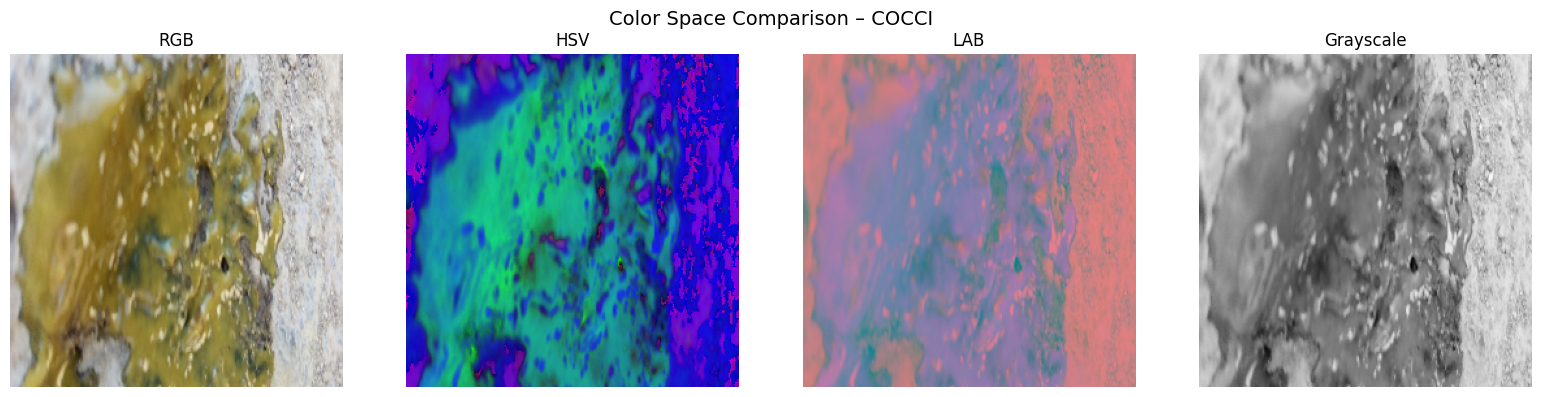

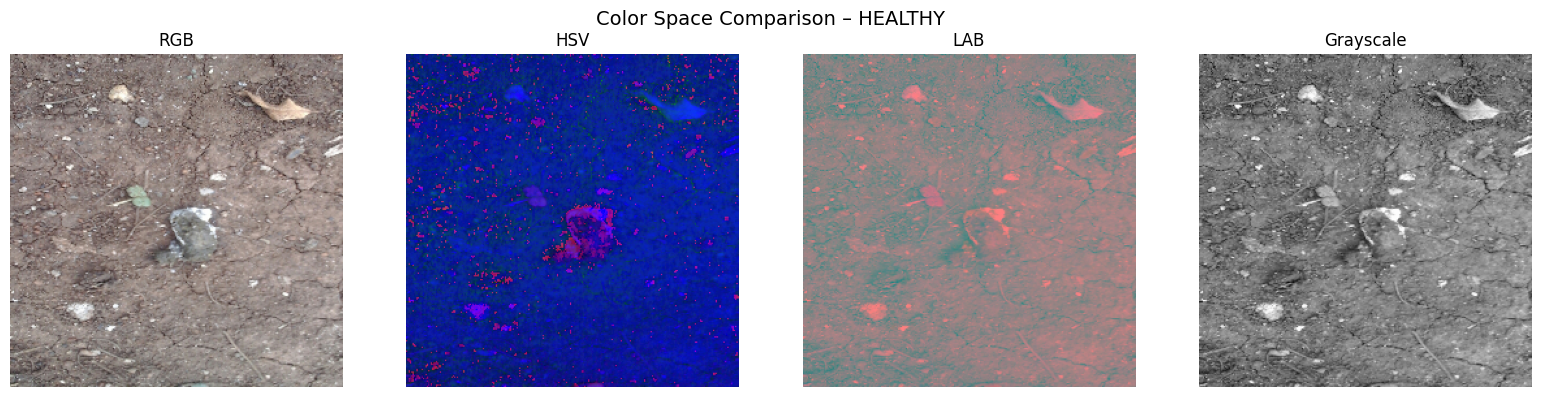

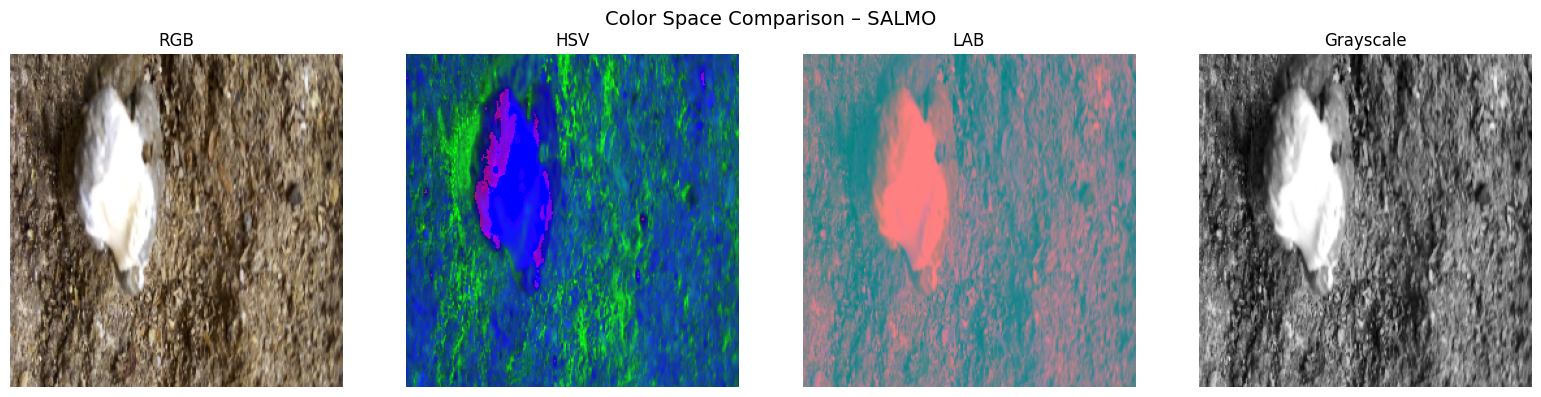

In [5]:
for cls in CLASS_NAMES:
    cls_dir = os.path.join(DATASET_PATH, cls)


    img_files = [f for f in os.listdir(cls_dir) if f.endswith(".jpg")]
    if len(img_files) == 0:
        continue

    img_path = os.path.join(cls_dir, img_files[0])
    img_bgr = cv2.imread(img_path)

    if img_bgr is None:
        continue

    img_bgr = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))

    img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    img_lab  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"Color Space Comparison – {cls.upper()}", fontsize=14)

    axes[0].imshow(img_rgb)
    axes[0].set_title("RGB")
    axes[0].axis("off")

    axes[1].imshow(img_hsv)
    axes[1].set_title("HSV")
    axes[1].axis("off")

    axes[2].imshow(img_lab)
    axes[2].set_title("LAB")
    axes[2].axis("off")

    axes[3].imshow(img_gray, cmap="gray")
    axes[3].set_title("Grayscale")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


In [6]:
X_train_path, X_temp_path, y_train_path, y_temp_path, y_train, y_temp = train_test_split(
    image_paths, label_paths, labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

X_val_path, X_test_path, y_val_path, y_test_path, y_val, y_test = train_test_split(
    X_temp_path, y_temp_path, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

### Feature Extraction

In [7]:
def color_histogram(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([image], [2], None, [256], [0, 256])

    cv2.normalize(hist_h, hist_h, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(hist_s, hist_s, 0, 255, cv2.NORM_MINMAX)
    cv2.normalize(hist_v, hist_v, 0, 255, cv2.NORM_MINMAX)

    return np.concatenate([
        hist_h.flatten(),
        hist_s.flatten(),
        hist_v.flatten()
    ]).astype(np.float32)

def ccm_feature(image, distances=[1],
                angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                levels=16):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(image)

    channels = {'H': H, 'S': S, 'V': V}
    all_features = []

    for _, ch in channels.items():
        max_val = np.max(ch)
        if max_val > 0:
            ch_q = (ch * (levels - 1) / max_val).astype(np.uint8)
        else:
            ch_q = np.zeros_like(ch, dtype=np.uint8)

        glcm = graycomatrix(
            ch_q,
            distances=distances,
            angles=angles,
            levels=levels,
            symmetric=True,
            normed=True
        )

        props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        feats = [graycoprops(glcm, p).ravel() for p in props]

        all_features.append(np.concatenate(feats))

    return np.concatenate(all_features).astype(np.float32)


def sobel_feature(image, n_bins_mag=16, n_bins_ang=16):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitude & orientation
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    orientation = np.arctan2(sobely, sobelx)

    mag_flat = magnitude.ravel()
    ori_flat = orientation.ravel()

    if mag_flat.max() > 0:
        mag_flat = mag_flat / mag_flat.max()

    hist_mag, _ = np.histogram(
        mag_flat,
        bins=n_bins_mag,
        range=(0.0, 1.0),
        density=True
    )

    hist_ori, _ = np.histogram(
        ori_flat,
        bins=n_bins_ang,
        range=(-np.pi, np.pi),
        density=True
    )

    return np.concatenate([hist_mag, hist_ori]).astype(np.float32)


In [8]:
def extract_features(img):
    return np.concatenate([
        color_histogram(img),
        ccm_feature(img),
        sobel_feature(img)
    ])

In [9]:
def crop_roi_from_yolo(img, label_path):
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        return None

    with open(label_path, "r") as f:
        line = f.readline().strip()
        if line == "":
            return None

        cls, xc, yc, bw, bh = map(float, line.split())

    xc *= w
    yc *= h
    bw *= w
    bh *= h

    x1 = int(xc - bw / 2)
    y1 = int(yc - bh / 2)
    x2 = int(xc + bw / 2)
    y2 = int(yc + bh / 2)

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    roi = img[y1:y2, x1:x2]
    if roi.size == 0:
        return None

    return roi, (x1, y1, x2 - x1, y2 - y1)

In [12]:
def prepare_data(img_paths, lbl_paths, labels):
    X, y = [], []

    for ip, lp, lb in zip(img_paths, lbl_paths, labels):
        img = cv2.imread(ip)
        if img is None:
            continue

        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        result = crop_roi_from_yolo(img, lp)
        if result is None:
            continue

        roi, bbox = result  # unpack (roi, bbox)

        if roi is None or roi.size == 0:
            continue

        roi = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))
        feat = extract_features(roi)

        if np.any(np.isnan(feat)):
            continue

        X.append(feat)
        y.append(lb)

    return np.array(X), np.array(y)


In [13]:
X_train, y_train = prepare_data(X_train_path, y_train_path, y_train)
X_val,   y_val   = prepare_data(X_val_path,   y_val_path,   y_val)
X_test,  y_test  = prepare_data(X_test_path,  y_test_path,  y_test)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=0.96, random_state=42)
X_train = pca.fit_transform(X_train)
X_val   = pca.transform(X_val)
X_test  = pca.transform(X_test)

In [15]:
svm = SVC(kernel="rbf", probability=True)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1]
}

grid = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=2)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .................................C=0.1, gamma=0.001; total time=   3.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   2.8s
[CV] END .................................C=0.1, gamma=0.001; total time=   2.8s
[CV] END .................................C=0.1, gamma=0.001; total time=   2.7s
[CV] END .................................C=0.1, gamma=0.001; total time=   2.7s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.5s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.4s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.2s
[CV] END ...................................C=0.

In [16]:
y_pred = best_svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

Accuracy: 0.9596273291925466
              precision    recall  f1-score   support

       cocci       0.96      0.98      0.97       316
     healthy       0.95      0.95      0.95       308
       salmo       0.96      0.94      0.95       342

    accuracy                           0.96       966
   macro avg       0.96      0.96      0.96       966
weighted avg       0.96      0.96      0.96       966



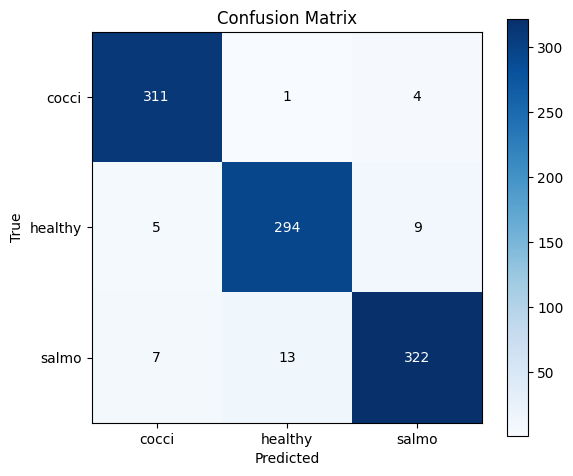

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i,
            cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > cm.max()/2 else "black"
        )

plt.colorbar()
plt.tight_layout()
plt.show()


In [18]:
def test_single_image(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    result = crop_roi_from_yolo(img, label_path)
    if result is None:
        print("ROI tidak ditemukan")
        return

    roi, (x, y, w, h) = result
    roi = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))

    feat = extract_features(roi)
    feat = scaler.transform([feat])
    feat = pca.transform(feat)

    pred_idx = best_svm.predict(feat)[0]
    pred_prob = best_svm.predict_proba(feat)[0]

    pred_class = CLASS_NAMES[pred_idx]

    boxed = img.copy()
    cv2.rectangle(boxed, (x, y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(boxed, pred_class, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    print("Predicted class:", pred_class)
    print("Probabilities:")
    for cls, p in zip(CLASS_NAMES, pred_prob):
        print(f"- {cls}: {p*100:.2f}%")

    plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

Predicted class: healthy
Probabilities:
- cocci: 0.00%
- healthy: 99.97%
- salmo: 0.03%


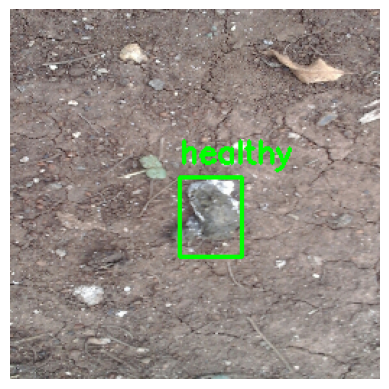

In [19]:
img_path   = "dataset/healthy/healthy.0.jpg"
label_path = "labels/healthy/healthy.0.txt"

test_single_image(img_path, label_path)

In [20]:
import pickle

model_bundle = {
    "scaler": scaler,
    "pca": pca,
    "model": best_svm,
    "class_names": CLASS_NAMES
}

with open("best_svm_final.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

print("Model + scaler + PCA saved!")


Model + scaler + PCA saved!
